In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [5]:
# 정규화
# 특성의 평균을 빼고 표준편차로 나누기
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [16]:
# 모델 정의
from keras import models
from keras import layers

def build_model(): # 동일한 모델을 여러번 생성할거라 함수로 만들기
    model = models.Sequential()
    # 훈련 데이터 개수 적을수록 과대적합 쉽게 일어남 -> 작은 모델 사용하기
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # 활성화 함수 없이 선형 층 -> 스칼라 회귀를 위한 구성
    # mse: 평균 제곱 오차 -> 예측과 타깃 사이 거리의 제곱
    # mae: 평균 절대 오차 -> 예측과 타깃 사이 거리의 절댓값
    #model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

In [19]:
# K-fold 교차검증
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print("처리중인 폴드 #", i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    # 훈련 데이터 준비: 나머지 분할 전체
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis=0)
    
    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)# verbose=0->훈련과정 출력X
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) # 검증 세트로 모델 평가
    all_scores.append(val_mae)

처리중인 폴드 # 0


2022-03-14 19:42:55.737998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:42:59.500935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


처리중인 폴드 # 1


2022-03-14 19:42:59.703145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:43:03.528046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


처리중인 폴드 # 2


2022-03-14 19:43:03.731914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:43:07.502373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


처리중인 폴드 # 3


2022-03-14 19:43:07.709012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:43:11.947517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [10]:
all_scores

[2.2916173934936523, 2.871204376220703, 2.6052770614624023, 2.4288601875305176]

In [11]:
np.mean(all_scores)

2.549239754676819

In [22]:
import tensorflow as tf
# 각 폴드 별 검증 점수 로그에 저장
num_epochs = 500 # 에포크 500으로 늘리기
all_mae_histories = []
for i in range(k):
    print("처리중인 폴드 #", i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    # 훈련 데이터 준비: 나머지 분할 전체
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis=0)
    
    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    history= model.fit(partial_train_data, partial_train_targets,
                       validation_data=(val_data, val_targets),
                       epochs=num_epochs, batch_size=1, verbose=0)# verbose=0->훈련과정 출력X
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0


2022-03-14 19:44:15.203358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:44:16.273317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


처리중인 폴드 # 1


2022-03-14 19:53:06.051445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:53:07.086464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


처리중인 폴드 # 2


2022-03-14 20:01:50.238373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 20:01:51.284339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


처리중인 폴드 # 3


2022-03-14 20:11:00.734384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 20:11:01.819195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


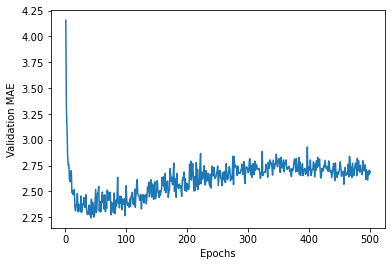

In [23]:
# 검증 점수 그래프
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

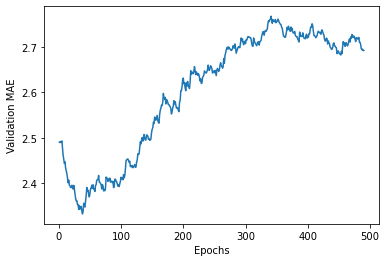

In [25]:
# 처음 10개의 데이터 포인트 제외한 검증 점수 그리기
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [28]:
# 최종 모델 훈련
model = build_model()
model.fit(train_data, train_targets, # 전체 데이터로 훈련
         epochs=80, batch_size=16, verbose=0) # 80번 에포크 이후 과대적합 발생
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

2022-03-14 20:33:39.498077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step - loss: 18.3306 - mean_absolute_error: 2.7737


2022-03-14 20:33:48.262177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2.7737131118774414